<a href="https://colab.research.google.com/github/kobrue02/evaluating-llm-generated-nlu-data/blob/main/bin/notebooks/evaluate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/kobrue02/evaluating-llm-generated-nlu-data/
%cd evaluating-llm-generated-nlu-data

Cloning into 'evaluating-llm-generated-nlu-data'...
remote: Enumerating objects: 1017, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 1017 (delta 78), reused 84 (delta 41), pack-reused 884 (from 1)
Receiving objects: 100% (1017/1017), 7.28 MiB | 14.42 MiB/s, done.
Resolving deltas: 100% (676/676), done.
/content/evaluating-llm-generated-nlu-data


In [2]:
import json
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

In [3]:
from bin.utils.methods import *
from bin.framework.framework import Framework

In [4]:
import logging
logging.basicConfig(level=logging.INFO)

In [5]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [15]:
dataset_names = [
    "attribute_controlled_prompt_data",
    "persona_based_prompt_s1_data",
    "chain_of_thought_simple_data",
    "zero_shot_simple_data",
    "one_shot_simple_data",
    "few_shot_simple_data",
]

In [9]:
ref_df = load_sipgate_dataset()

load phi data

In [17]:
phi_dfs = [load_df(f"phi/{dataset_name}") for dataset_name in dataset_names]

In [18]:
llama_dfs = [load_df(f"llama/llama_{dataset_name}") for dataset_name in dataset_names]

In [19]:
framework = Framework()
evaluated_sets_phi = []
for gen_df in phi_dfs:
  results = framework.apply_framework_to_datasets(gen_df, ref_df)
  df = results_to_dataframe(results)
  evaluated_sets_phi.append(df)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

 88%|████████▊ | 80/91 [00:24<00:05,  2.05it/s]/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 10%|▉         | 9/92 [00:02<00:20,  4.03it/s]/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 18%|█▊        | 17/92 [00:06<00:33,  2.24it/s]/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_

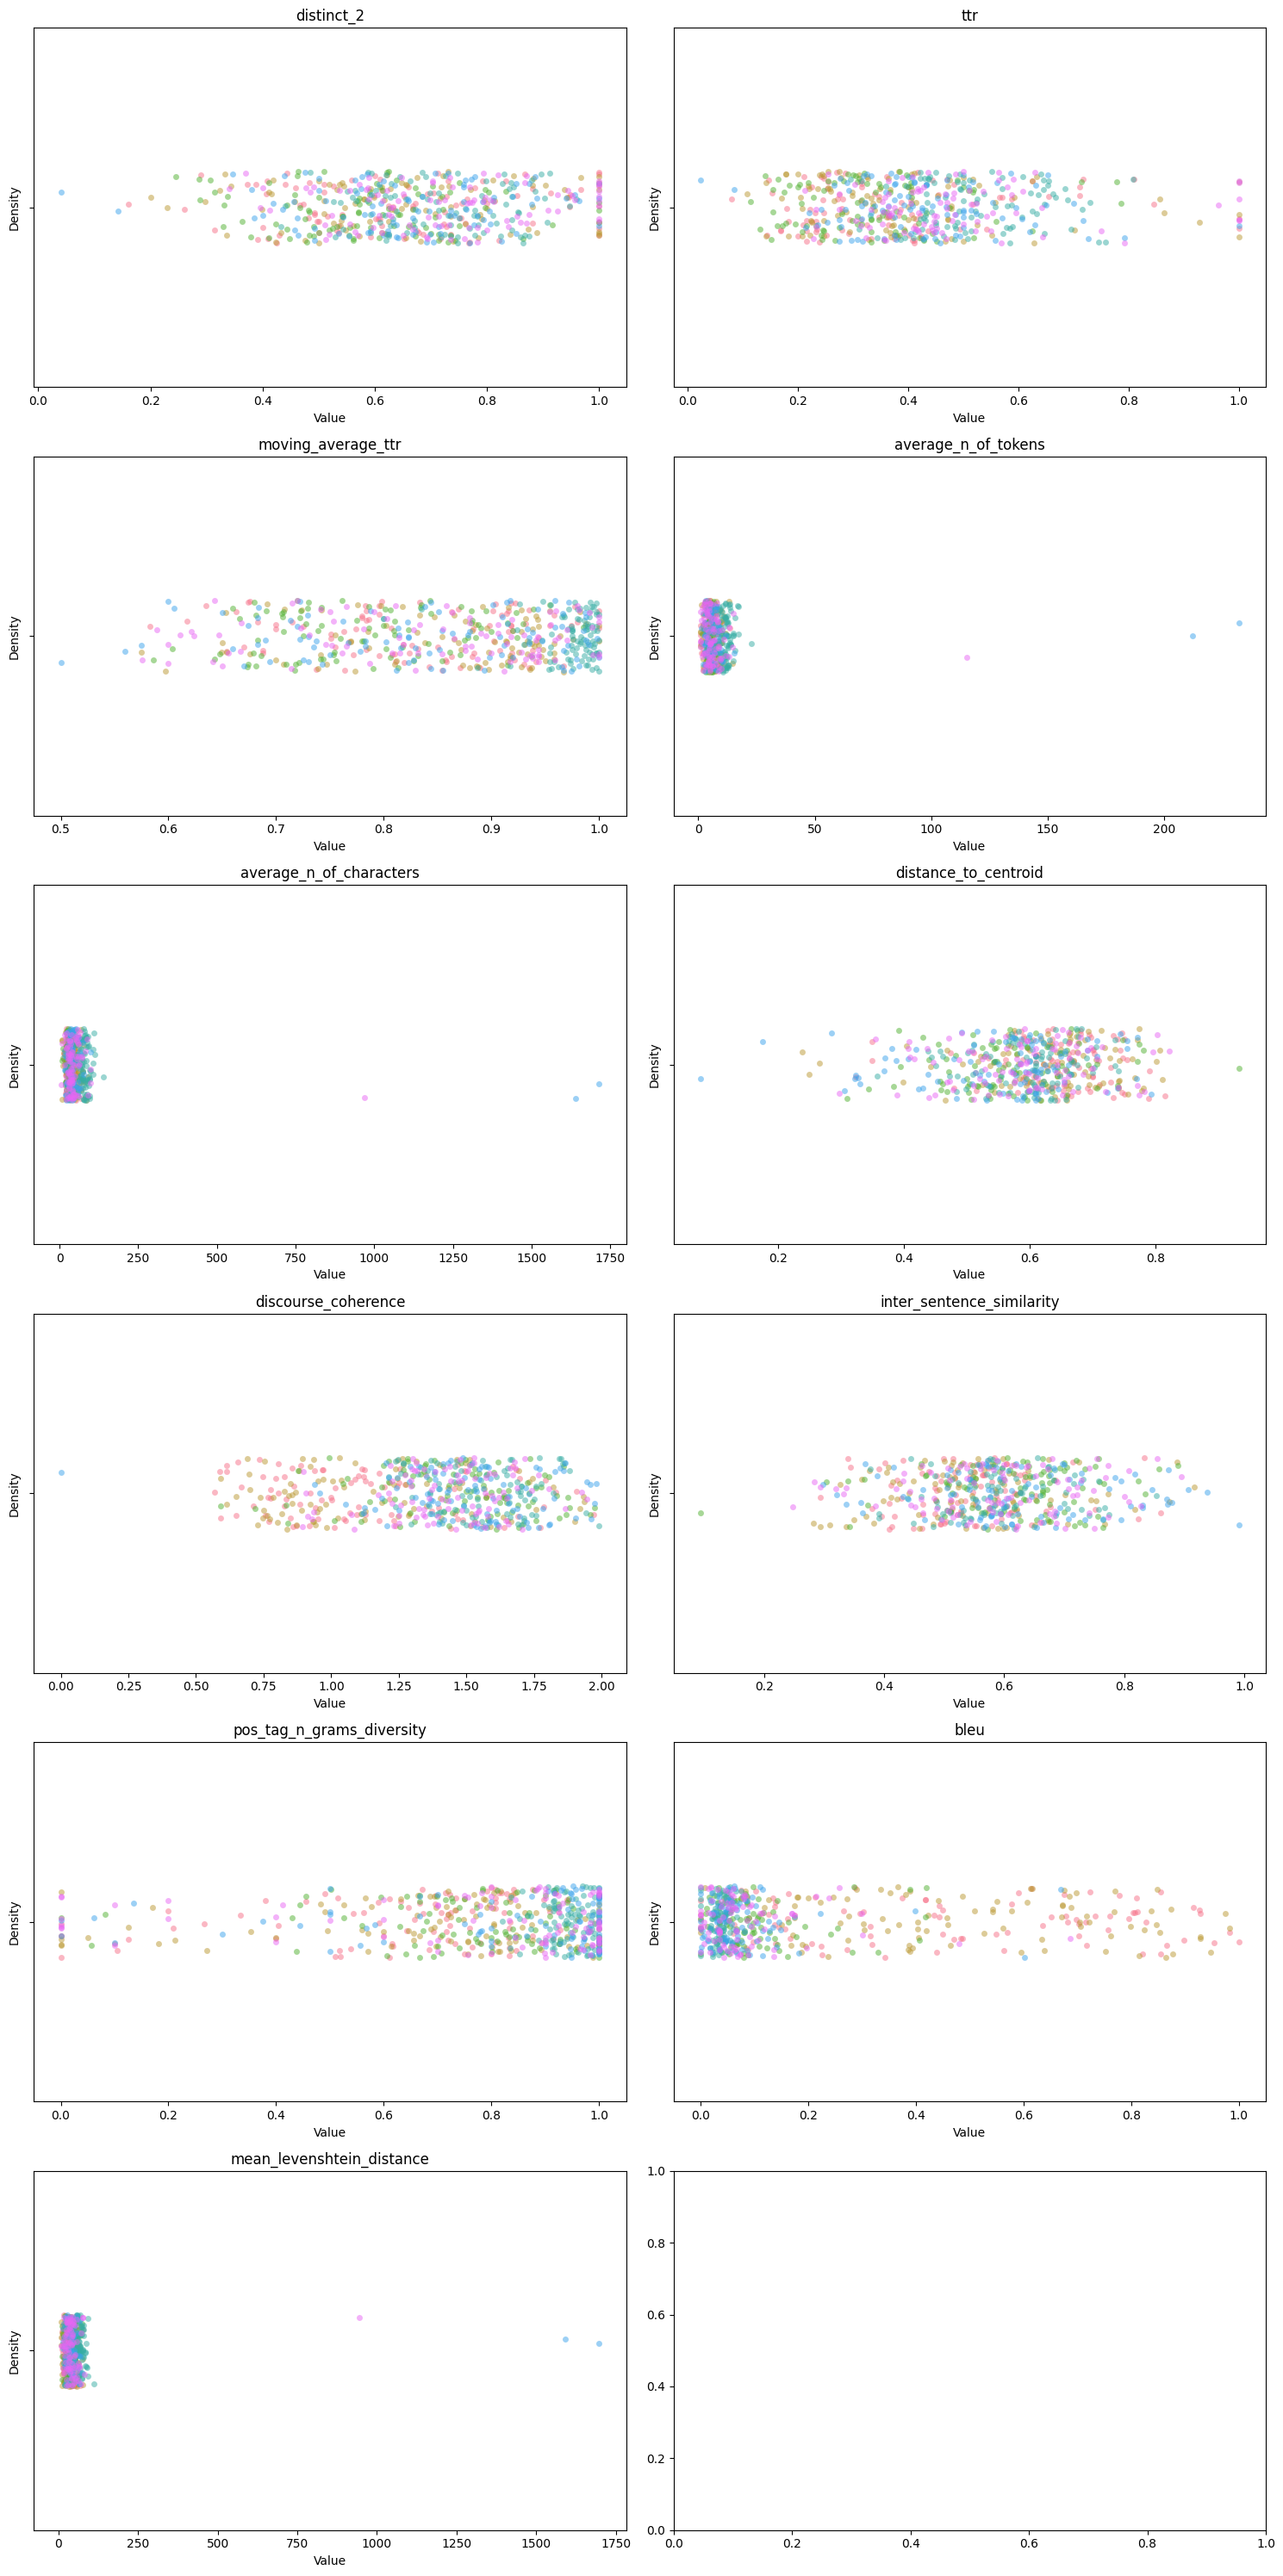

In [20]:
dfs_to_stripplots(evaluated_sets_phi)

In [21]:
framework = Framework()
evaluated_sets_llama = []
for gen_df in llama_dfs:
  results = framework.apply_framework_to_datasets(gen_df, ref_df)
  df = results_to_dataframe(results)
  evaluated_sets_llama.append(df)

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

 43%|████▎     | 40/92 [00:21<00:08,  6.25it/s]/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 92/92 [00:23<00:00,  3.98it/s]


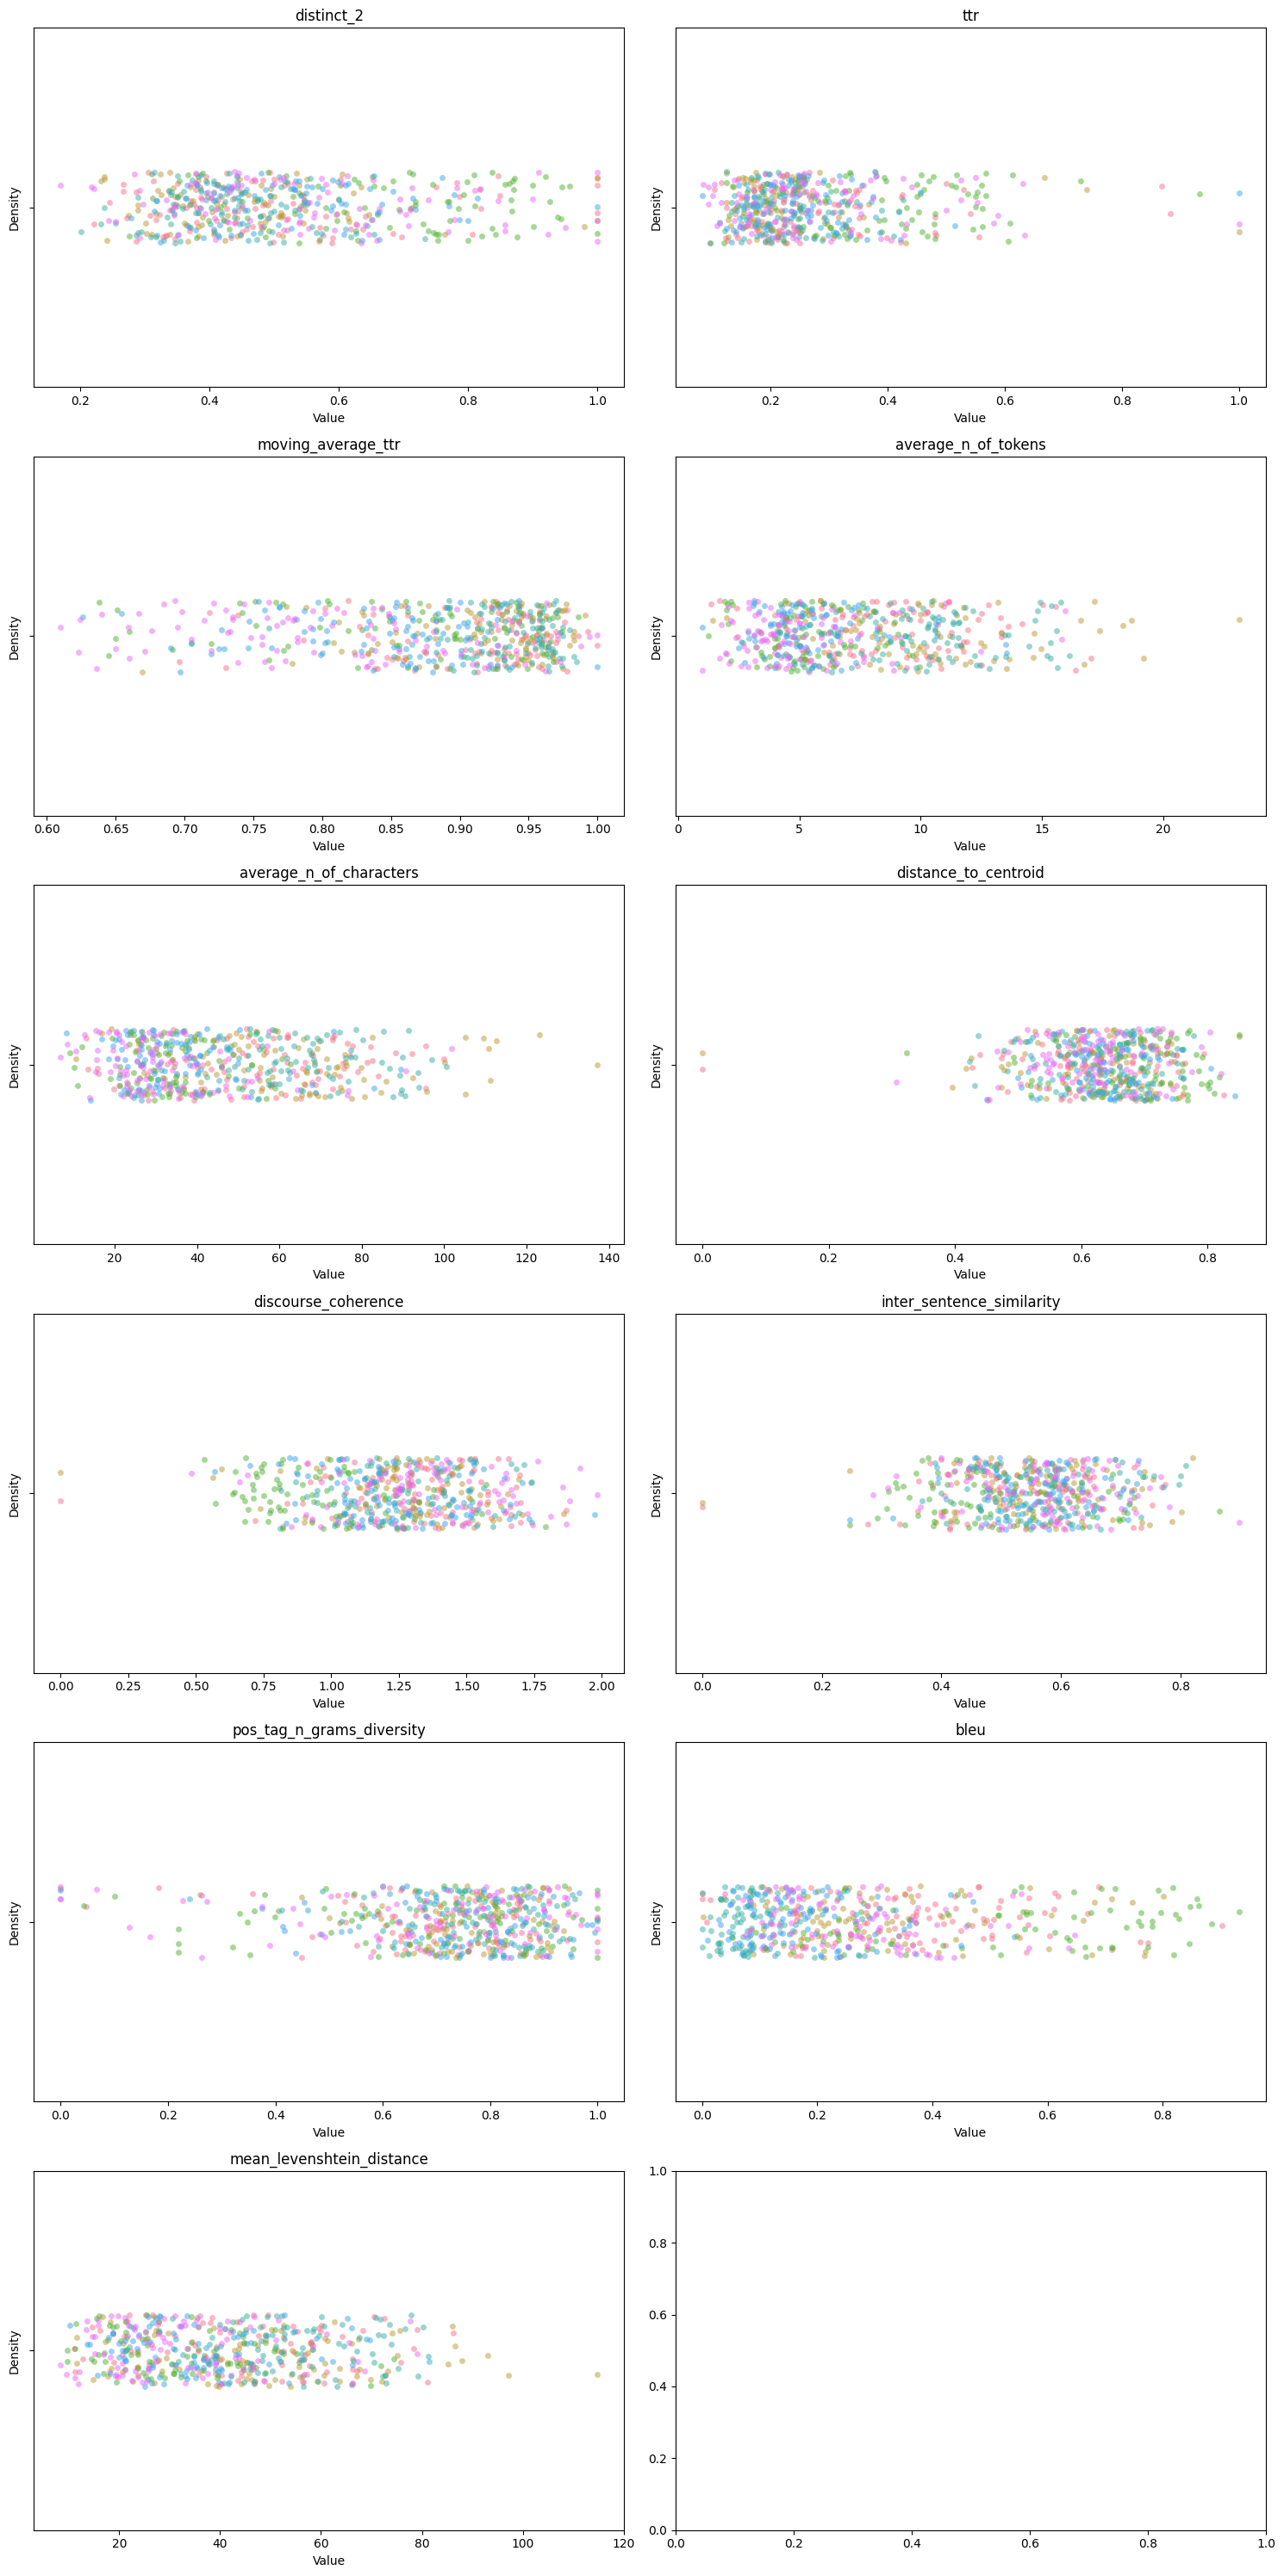

In [22]:
dfs_to_stripplots(evaluated_sets_llama)

In [32]:
# prompt: create a function that merges all dataframes in evaluated_sets_phi into one dataframe with a new column called "Prompting Strategy" that takes the respective name from dataset_names iteratively

import pandas as pd

def merge_dataframes(evaluated_sets, dataset_names):
    """Merges a list of dataframes into a single dataframe with a new column indicating the prompting strategy.

    Args:
        evaluated_sets: A list of pandas DataFrames.
        dataset_names: A list of strings representing the prompting strategy names.

    Returns:
        A single pandas DataFrame with all data merged and a new "Prompting Strategy" column.
        Returns None if input lists are not of equal length or if any error occurs during processing.
    """
    if len(evaluated_sets) != len(dataset_names):
        print("Error: evaluated_sets and dataset_names must have the same length.")
        return None

    try:
        merged_df = pd.DataFrame()
        for i, df in enumerate(evaluated_sets):
            df['Prompting Strategy'] = dataset_names[i]
            merged_df = pd.concat([merged_df, df], ignore_index=True)
        return merged_df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [35]:
merged_phi_df = merge_dataframes(evaluated_sets_phi, dataset_names)
merged_llama_df = merge_dataframes(evaluated_sets_llama, dataset_names)

In [37]:
# prompt: now concatenate the two merged dataframes and add a new column "Model"

concatenated_df = pd.concat([merged_phi_df, merged_llama_df], ignore_index=True)
concatenated_df["Model"] = ""  # Add a new column named "Model" initialized with empty strings
concatenated_df.loc[concatenated_df.index < len(merged_phi_df), "Model"] = "Phi"
concatenated_df.loc[concatenated_df.index >= len(merged_phi_df), "Model"] = "Llama"

In [38]:
concatenated_df

,distinct_1,distinct_2,ttr,moving_average_ttr,average_n_of_tokens,average_n_of_characters,distance_to_centroid,discourse_coherence,inter_sentence_similarity,pos_tag_n_grams_diversity,bleu,mean_levenshtein_distance,intent,Model,Dataset,Prompting Strategy
0,0.304,0.527,0.286,0.635,4.308,30.538,0.597,1.245,0.604,0.942,0.138,23.778,account_activate_item,Phi,0,attribute_controlled_prompt_data
1,0.401,0.745,0.386,0.902,7.880,48.720,0.630,0.857,0.568,0.734,1.000,39.360,account_activate_item_not_possible,Phi,0,attribute_controlled_prompt_data
2,0.201,0.388,0.201,0.898,7.160,42.520,0.633,1.197,0.554,0.846,0.272,30.054,account_ask_item_available,Phi,0,attribute_controlled_prompt_data
3,0.314,0.624,0.256,0.751,3.440,23.520,0.631,1.054,0.574,0.399,0.578,17.686,account_delete_item,Phi,0,attribute_controlled_prompt_data
4,0.333,0.500,0.281,0.764,5.182,29.364,0.613,1.560,0.563,0.894,0.682,21.473,account_get_item,Phi,0,attribute_controlled_prompt_data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1094,0.268,0.518,0.239,0.837,5.917,37.000,0.578,1.160,0.637,0.868,0.133,33.378,request_migrate_product,Llama,5,few_shot_simple_data
1095,0.550,1.000,0.550,0.780,2.000,18.600,0.599,1.299,0.595,0.000,0.103,35.600,routing_set_time_profile,Llama,5,few_shot_simple_data
1096,0.359,0.632,0.333,0.807,3.900,22.000,0.685,1.629,0.474,0.825,0.370,20.640,service_disruption_inquire,Llama,5,few_shot_simple_data
1097,0.236,0.563,0.222,0.698,3.429,29.143,0.546,1.404,0.666,0.492,0.113,22.973,softphone_request_info,Llama,5,few_shot_simple_data


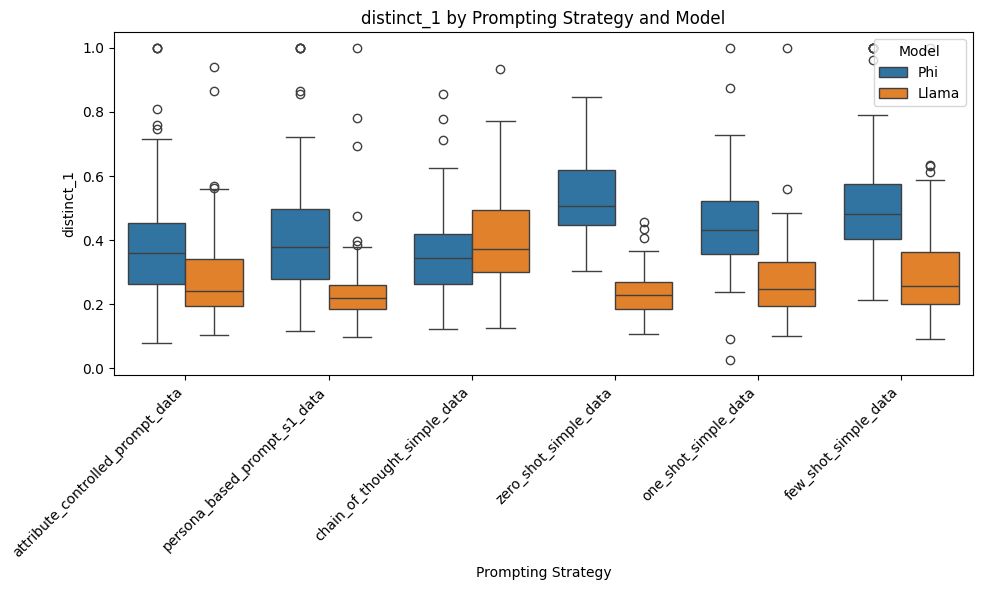

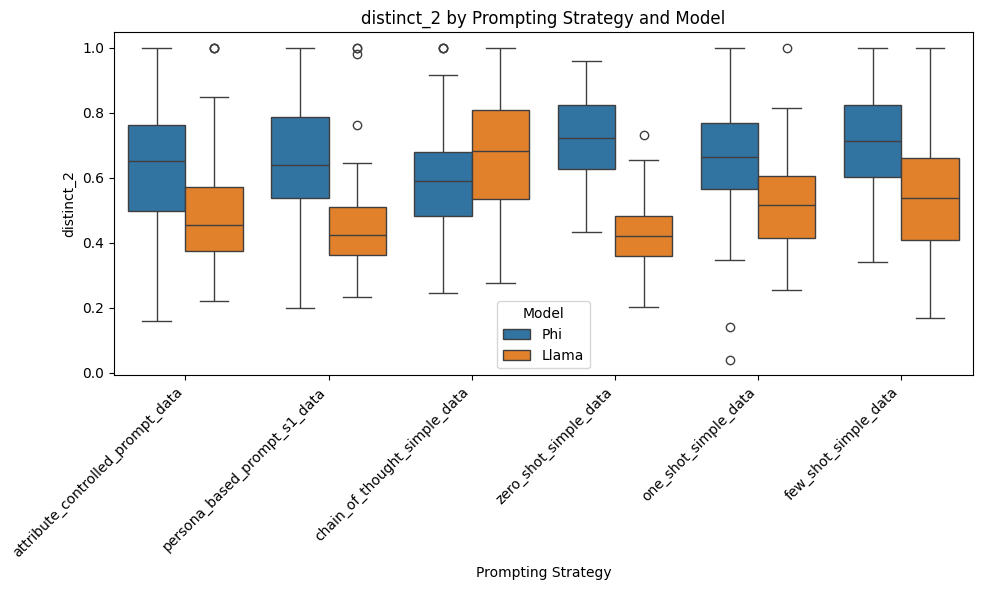

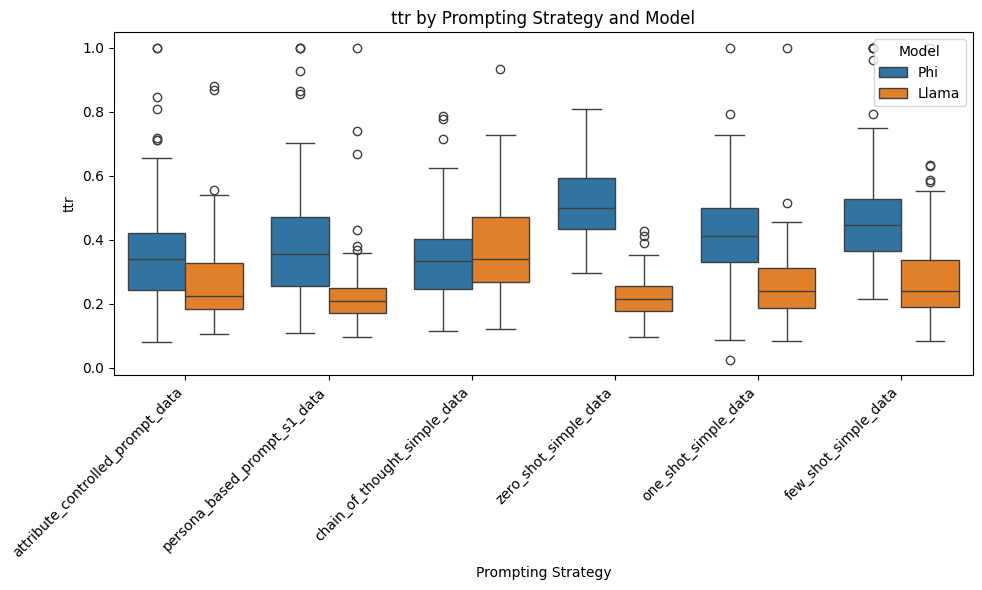

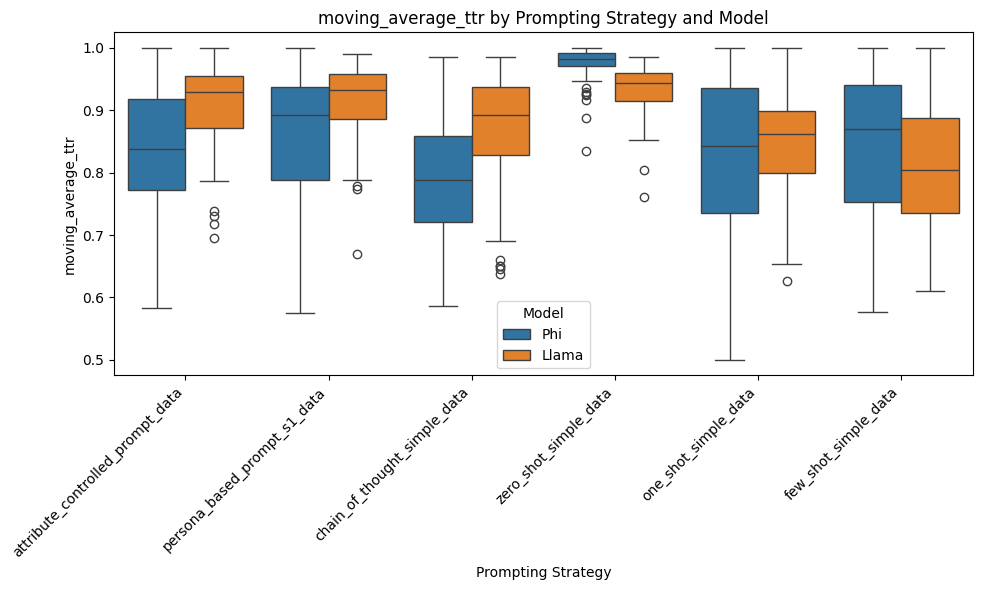

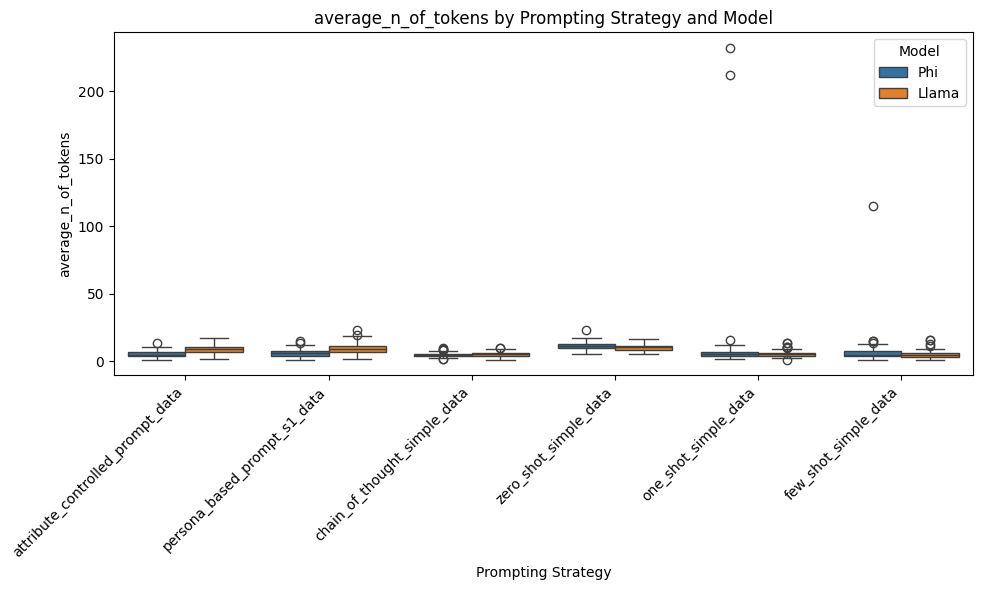

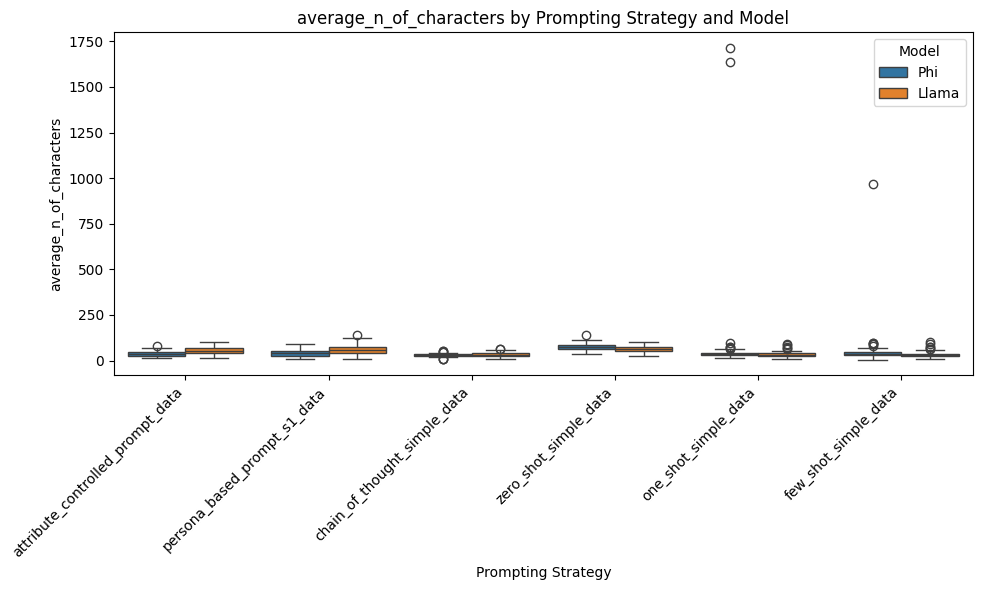

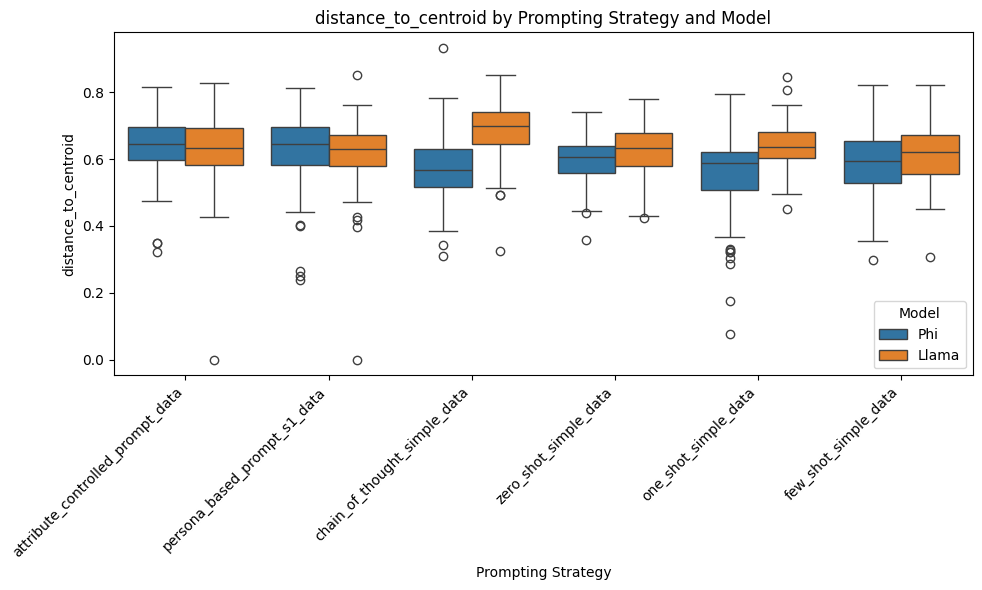

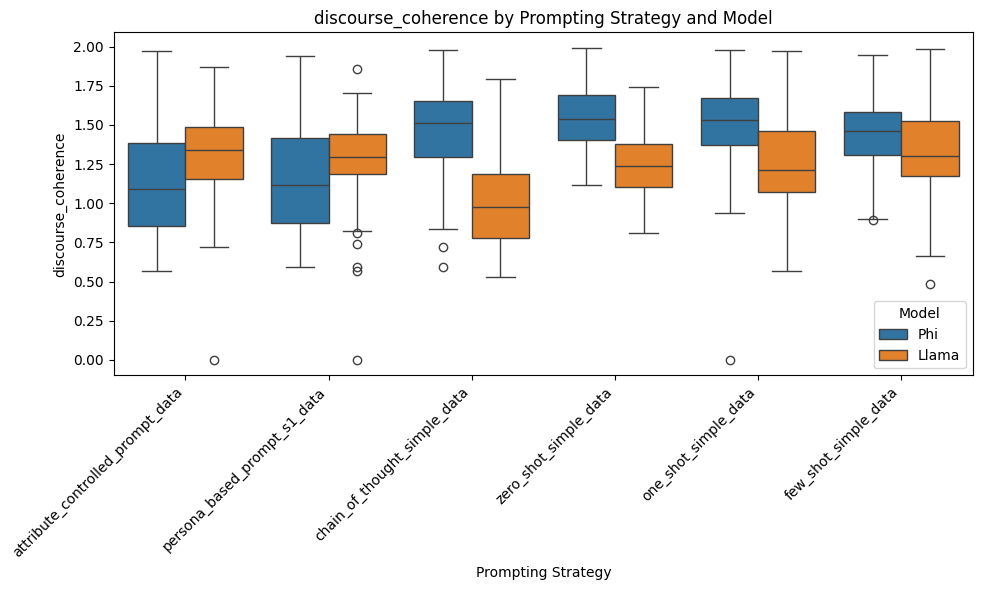

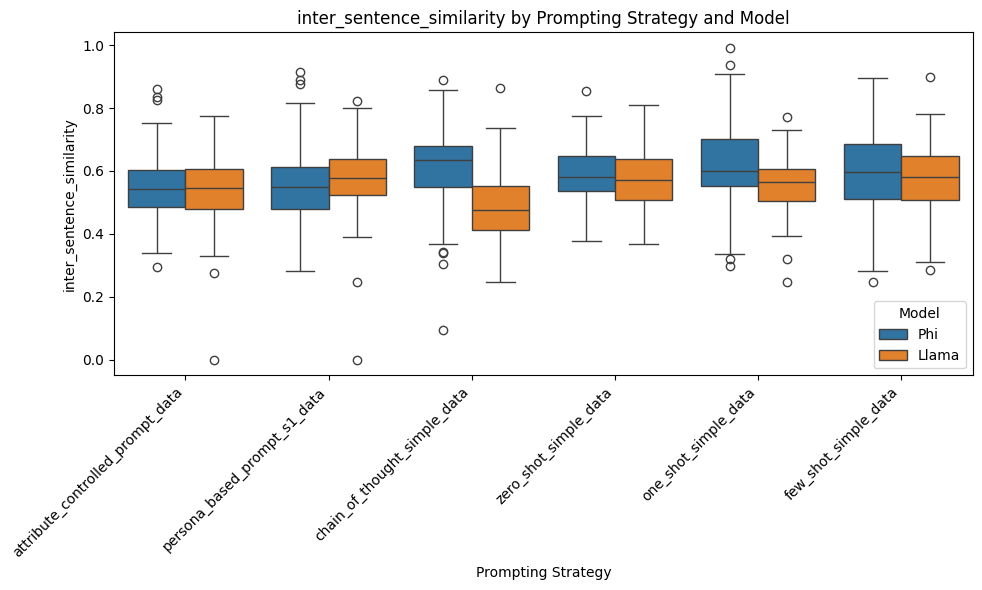

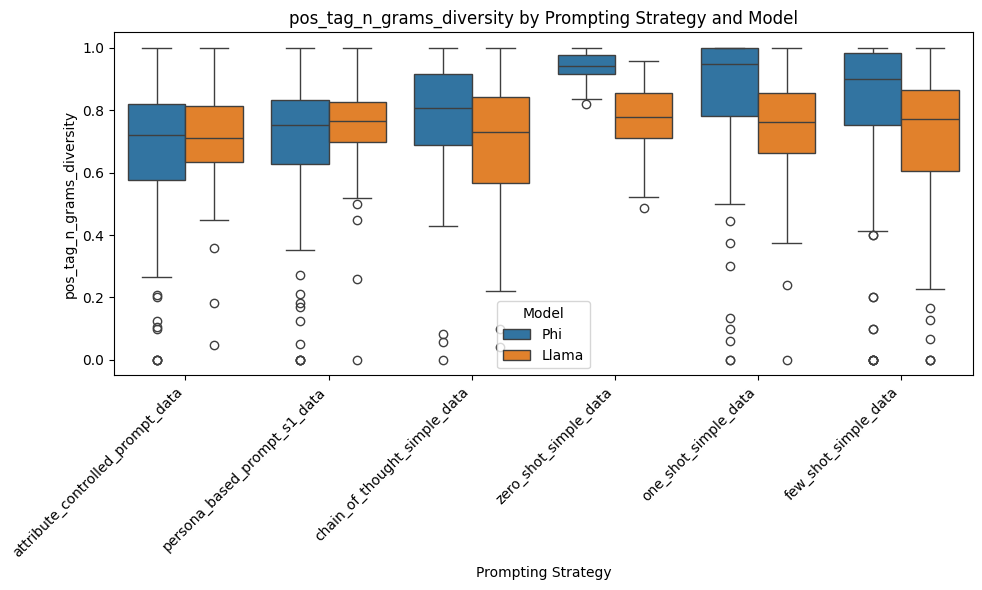

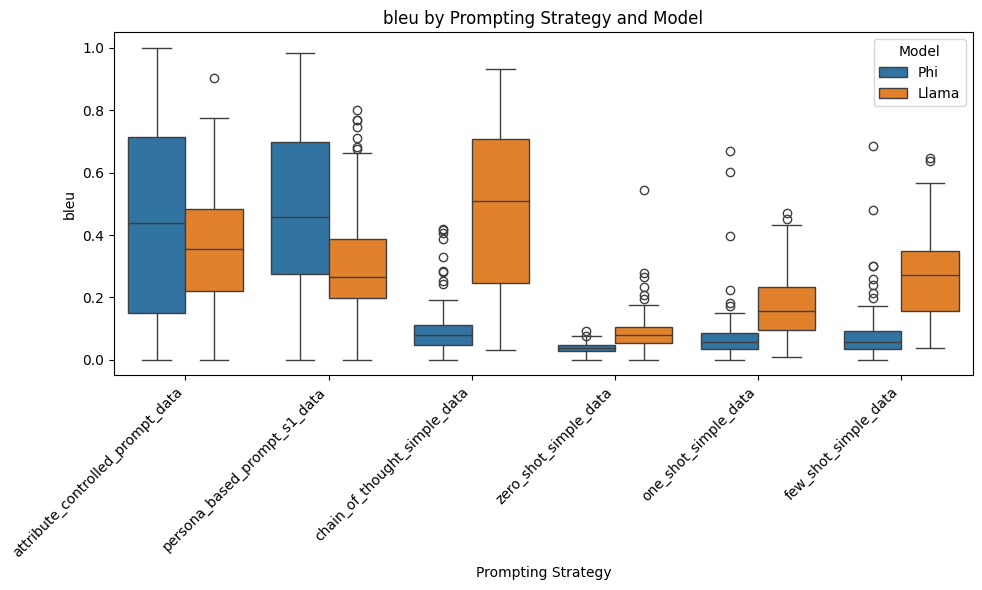

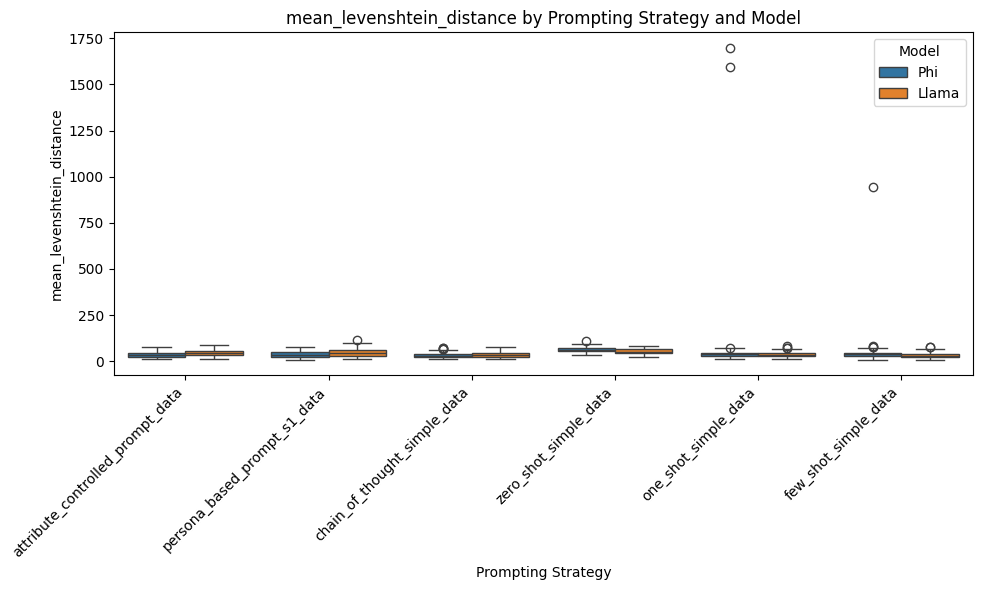

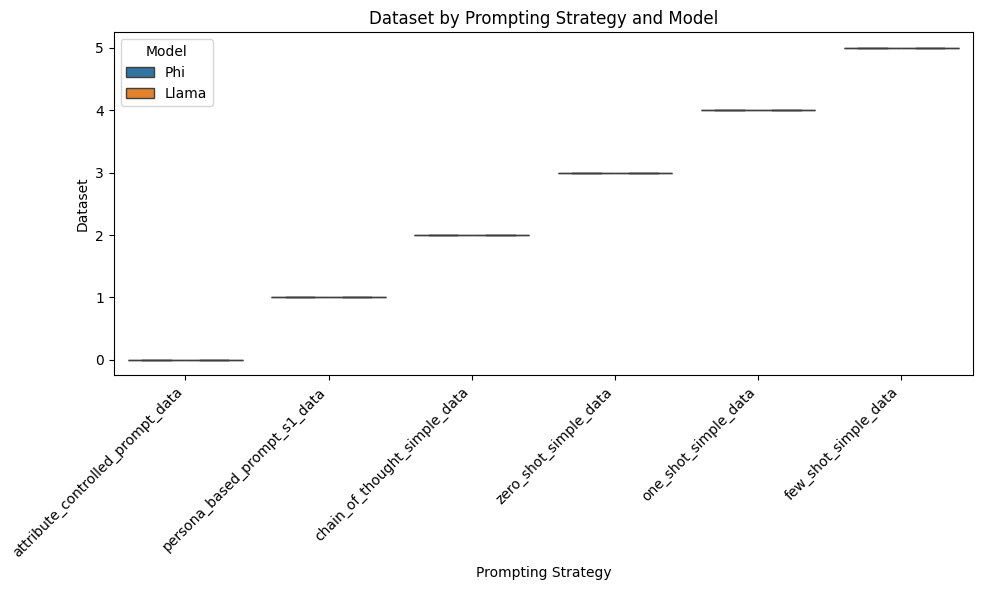

In [42]:
# prompt: make plots for each metric in concatenated_df and use the "Model" column for hue and "Prompting Strategy" on the x Axis

# Assuming concatenated_df is already defined as in the previous code

metrics = [col for col in concatenated_df.columns if col not in ["Prompting Strategy", "Model"]]

for metric in metrics:
    if metric in ["intent", "dataset"]:
        continue
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Prompting Strategy", y=metric, hue="Model", data=concatenated_df)
    plt.title(f"{metric} by Prompting Strategy and Model")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
phi_metric_dfs = transform_dfs_to_metric_dfs(evaluated_sets_phi, dataset_names)
metric_names = list(framework.metrics)

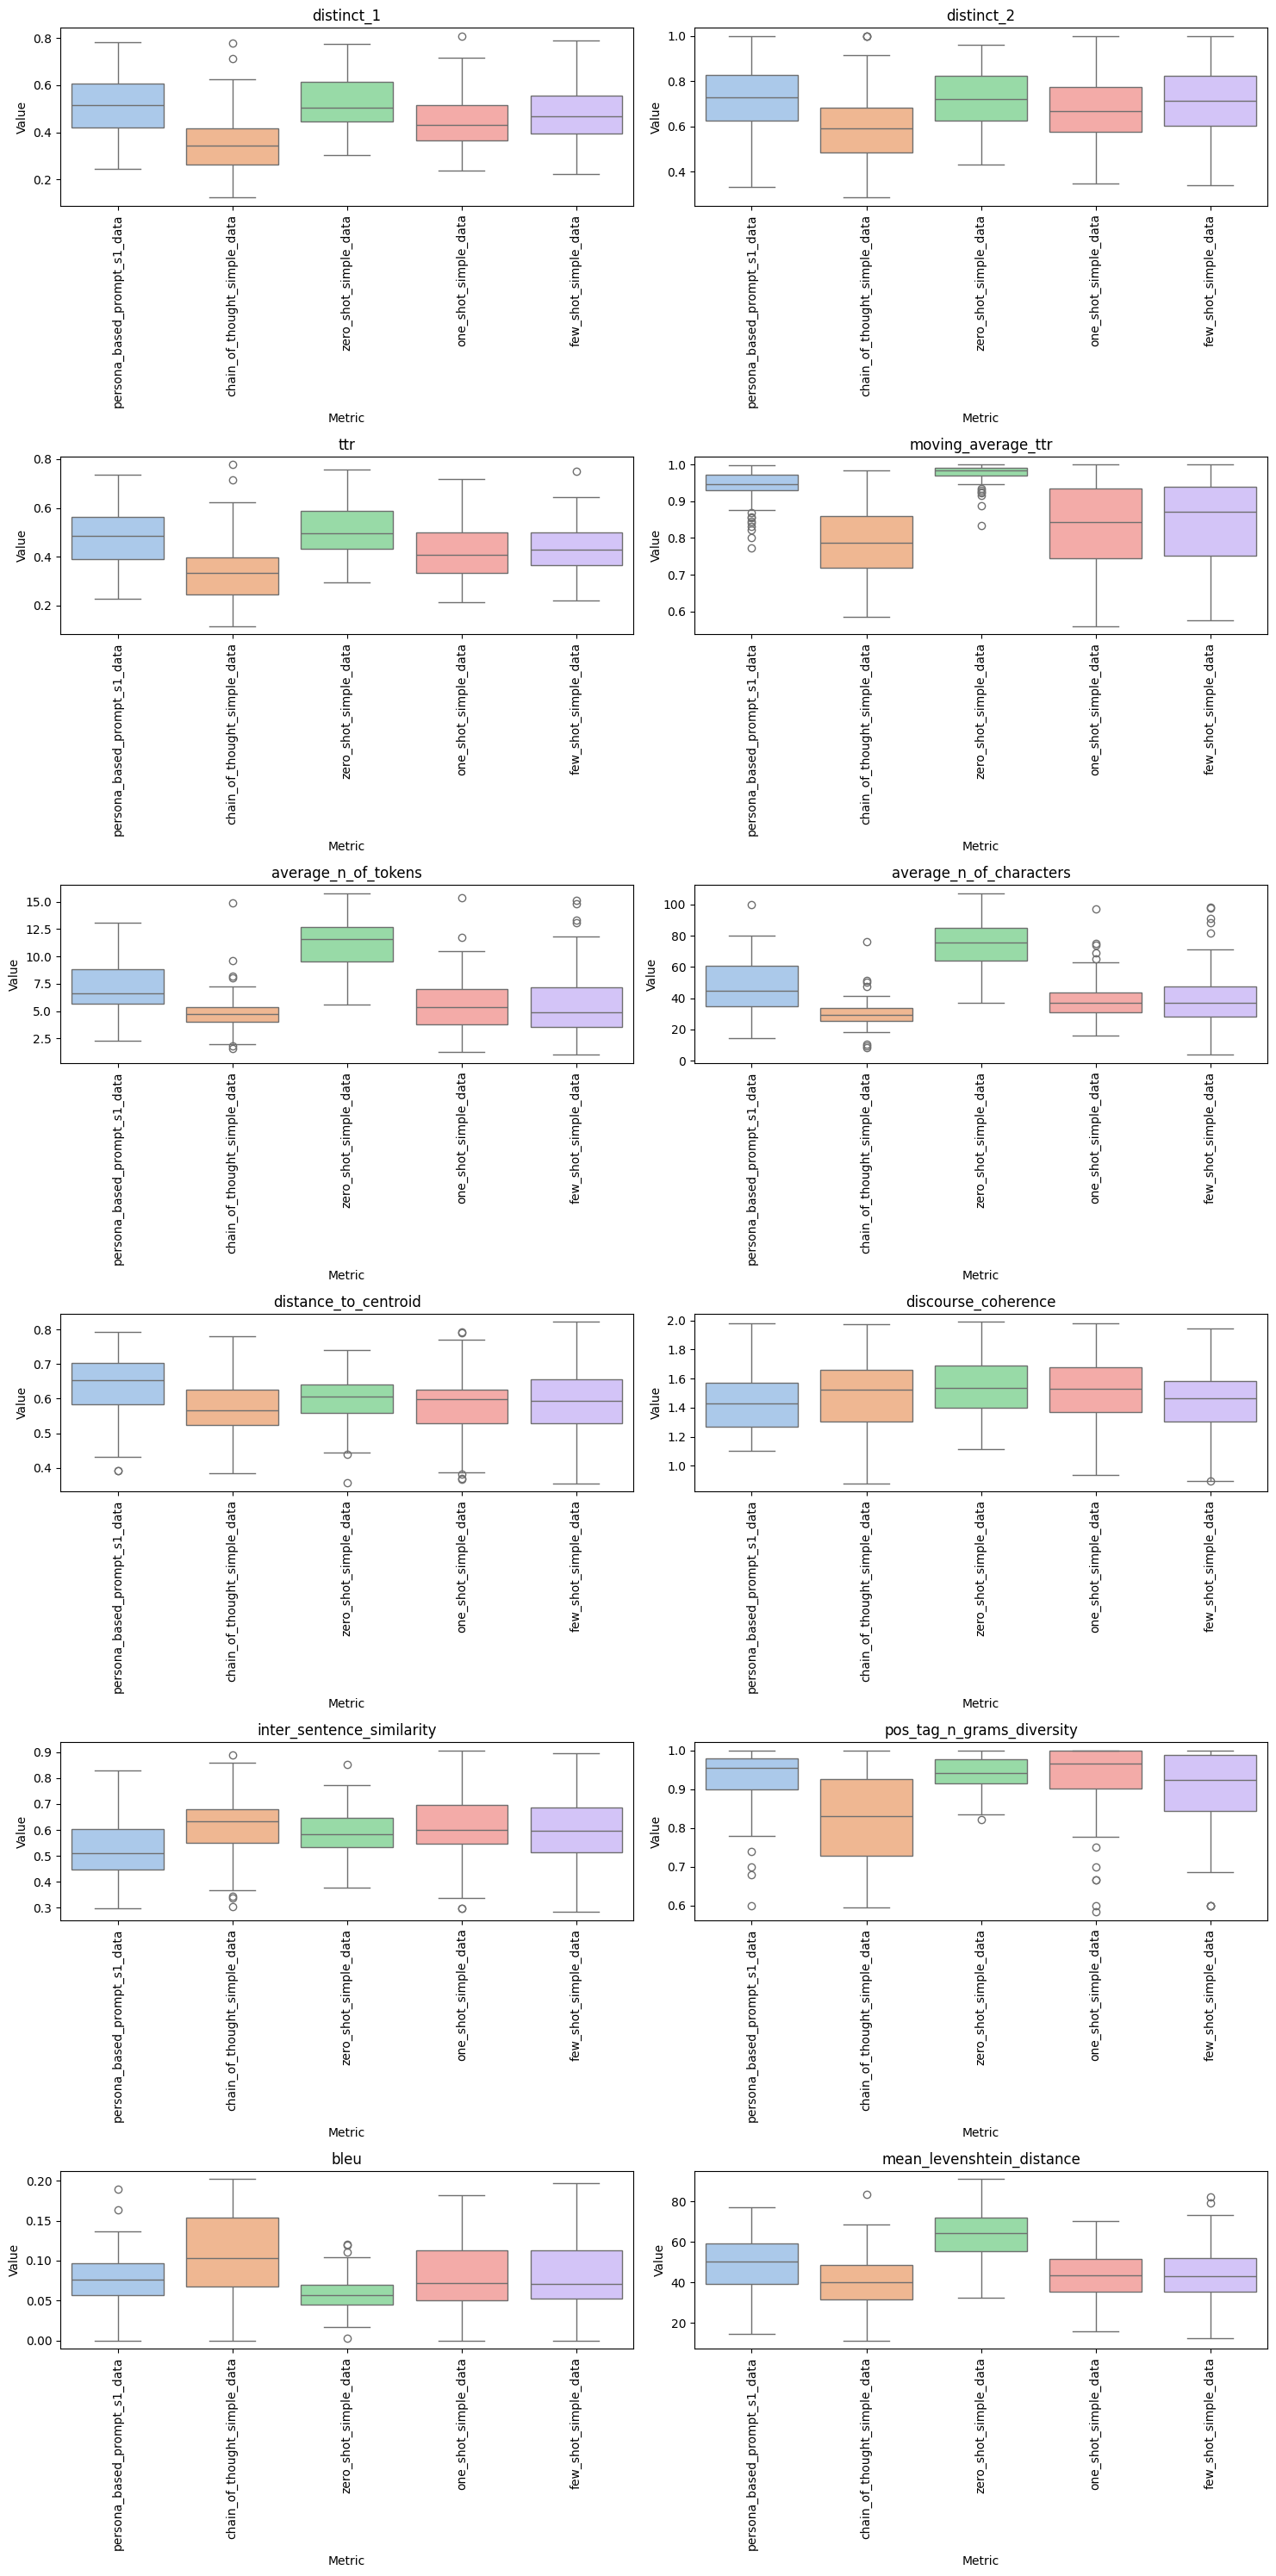

In [ ]:
catplot_metric_dfs(metric_dfs, metric_names)

In [ ]:
dfs = [
    framework.apply_framework_to_datasets(load_df(dataset_name))
    for dataset_name in dataset_names
]
dfs.append(framework.apply_framework_to_datasets(ref_df))

In [ ]:
result_dfs = [results_to_dataframe(df) for df in dfs]
transformed_dfs = transform_dfs_to_metric_dfs(
    result_dfs,
    columns= ["intent"] + dataset_names + ["sipgate"],
    dataset_names=dataset_names)
metric_names = list(framework.hypotheses_metrics)

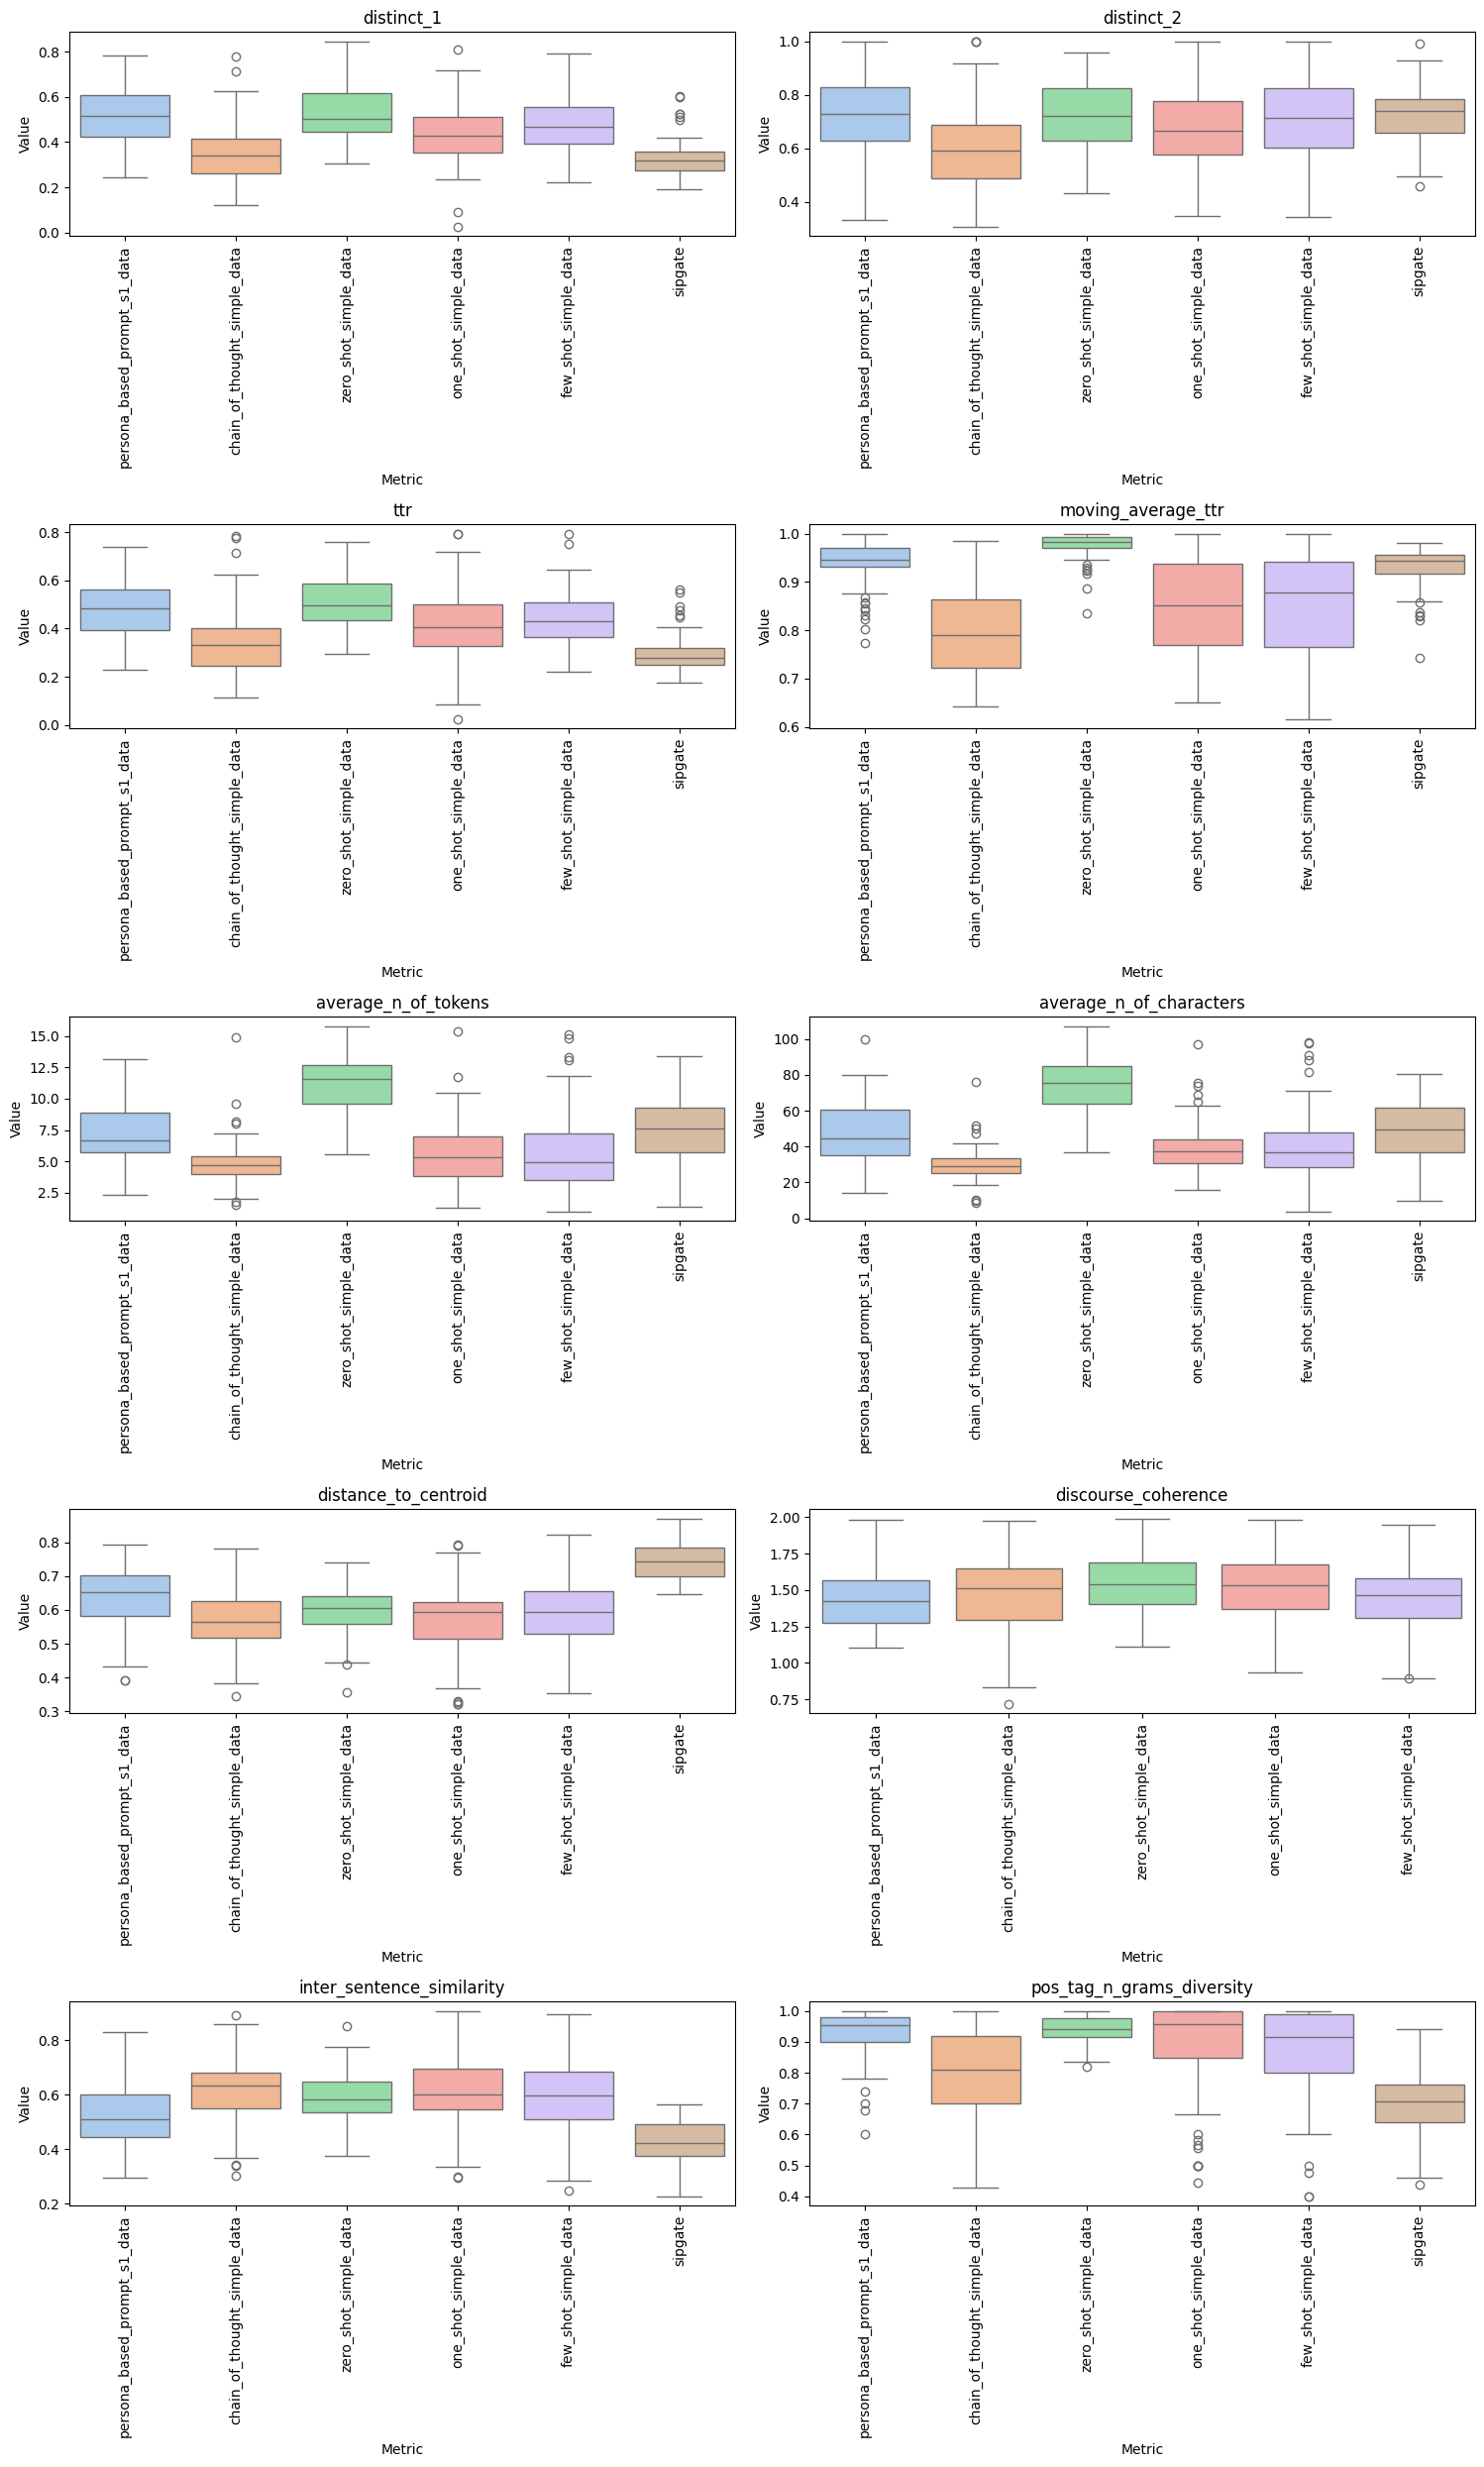

In [ ]:
catplot_metric_dfs(transformed_dfs, framework.hypotheses_metrics)

In [ ]:
from scipy.spatial.distance import jensenshannon
def js_divergence(p, q):
  p = np.asarray(p)
  q = np.asarray(q)
  return jensenshannon(p, q)

In [ ]:
divergences = {}
for i, metric in enumerate(transformed_dfs):
    metric_name = metric_names[i].name
    divergences[metric_name] = {}
    golden_dist = metric.sipgate.tolist()
    for source in metric.columns[:-2]:
      dist = metric[source].tolist()
      divergence = js_divergence(golden_dist, dist)
      divergences[metric_name][source] = divergence

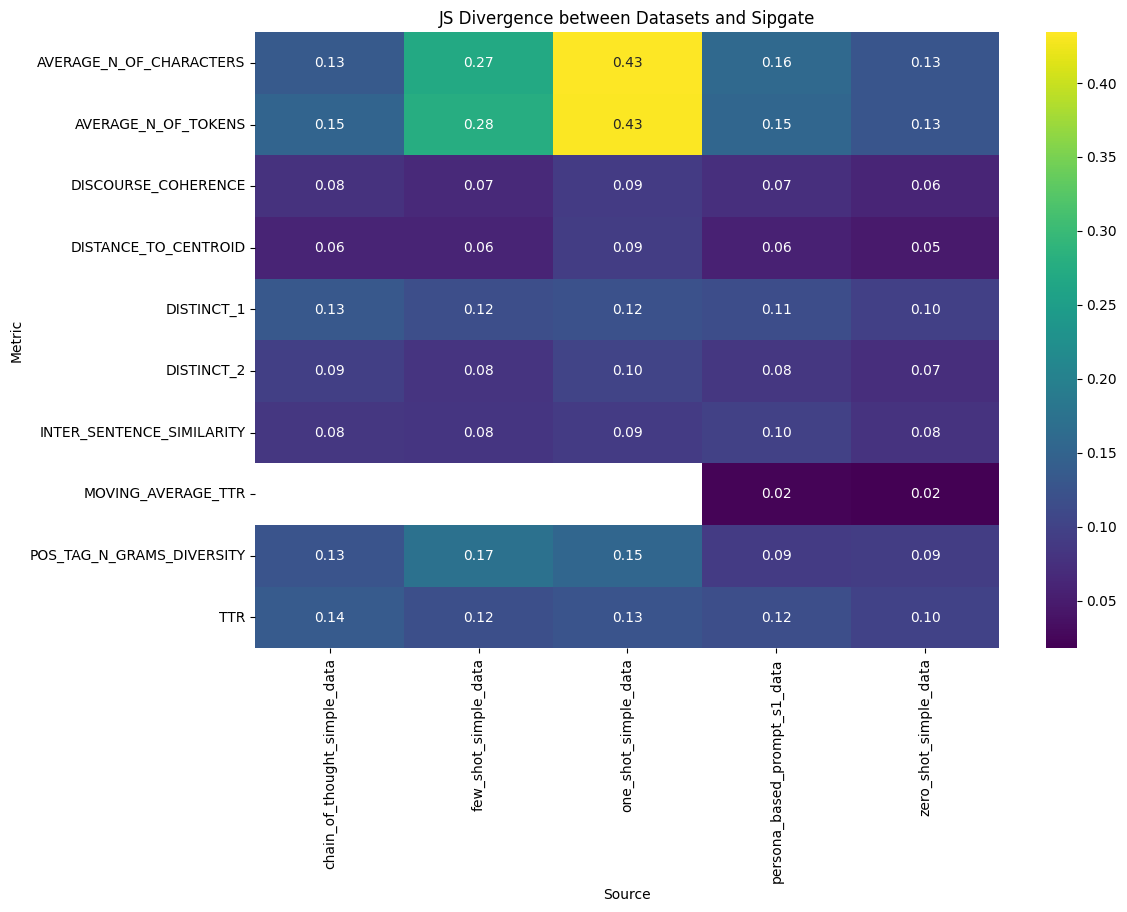

In [ ]:
# prompt: generate a heatmap with the dataset sources on one axis and the metrics on the other axis

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'divergences' is a dictionary as defined in your previous code
# Create a DataFrame from the divergences dictionary
divergence_df = pd.DataFrame(divergences).T.reset_index()
divergence_df = pd.melt(divergence_df, id_vars=['index'], var_name='Source', value_name='JS Divergence')
divergence_df = divergence_df.rename(columns={'index': 'Metric'})

# Create the heatmap
plt.figure(figsize=(12, 8))
# The pivot function was called incorrectly, it should be called like this:
sns.heatmap(divergence_df.pivot(index='Metric', columns='Source', values='JS Divergence'), annot=True, cmap='viridis', fmt=".2f")
plt.title('JS Divergence between Datasets and Sipgate')
plt.show()